In [1]:
#v1.01 キャビテーション数を追加、Ssの切替機能を追加、メタン対応
#v1.02 インプット改良、ファイルパスの改良、多段インペラのインプットに対応、グラフ出力を実装
import csv
import numpy as np
import math
import pandas as pd

#inputファイルの名前定義
input_file = "input_file"

#CSVの本読み込み
csv_file = open(input_file+".csv", "r", encoding="ms932", errors="", newline="" )
f = csv.reader(csv_file, delimiter=",", doublequote=True, lineterminator="\r\n", quotechar='"', skipinitialspace=True)


In [2]:
#input一覧を見たい時に使う
#import math
#import pandas as pd
csv_input = pd.read_csv(filepath_or_buffer=input_file+".csv", encoding="ms932", sep=",")
#inputの確認
#返り値型は、numpy.ndarray
#print(csv_input)

In [3]:
#loop数を確認
#print(len(csv_input))
#print(len(csv_input.columns))

#input一覧
csv_input[:len(csv_input)]

,必要揚程[m],密度[kg/m3],流量[kg/s],ポンプ回転数[RPM],ポンプ入口圧力[MPaA],ポンプ 体積効率[-],ポンプ 効率[-],ポンプ段数[-],シャフト直径[m]
0,650,1143,13.4,12000,0.5,0.95,0.6,1,0.025
1,650,1143,13.4,14000,0.5,0.95,0.6,1,0.025
2,650,1143,13.4,16000,0.5,0.95,0.6,1,0.025
3,650,1143,13.4,18000,0.5,0.95,0.6,1,0.025
4,650,1143,13.4,20000,0.5,0.95,0.6,1,0.025
5,650,1143,13.4,22000,0.5,0.95,0.6,1,0.025
6,650,1143,13.4,24000,0.5,0.95,0.6,1,0.025
7,650,1143,13.4,26000,0.5,0.95,0.6,1,0.025
8,650,1143,13.4,28000,0.5,0.95,0.6,1,0.025
9,650,1143,13.4,30000,0.5,0.95,0.6,1,0.025


In [4]:
#関数定義①
#比速度から翼枚数を選択する関数

def select_blade_no(Ns):
    #if Ns <= 30:
        #print("too small Ns!!")
    #elif Ns < 200:
       # return (5)
    
    if Ns <= 200:
        return (5)
    elif Ns <= 300:
        return (6)
    else:
        return (7)

In [5]:
#必要な関数を定義②

#ポンプ入口流速を経験式から計算
def inlet_speed_coef(Ns):
    ks = -1 * 10**(-7) * Ns**2 + 3 * 10**(-4) * Ns + 0.0657 
    return ks

#ステパノフ線図の22.5°から周速度係数ku2を算出
def outlet_cirspeed_coef(Ns):
    ku2 = -7 * 10**(-21) * Ns**2 + 5 * 10**(-4) * Ns + 0.9
    return ku2

#ステパノフ線図の22.5°から出口半径方向速度k2mを算出
def outlet_radspeed_coef(Ns):
    k2m = ( -2 * 10**(-7) * Ns**2 + 2.8  *10**(-3) * Ns + 0.5834 ) / 10
    return k2m

#線図からボリュート室係数kd5を算出
def volute_coef(Ns):
    kd5 = ( 7.7 * Ns**0.9 ) / 10000
    return kd5

#線図からボリュート室内部流量係数kvoを算出
def volute_speed_coef(Ns):
    kvo = -0.118 * math.log(Ns) + 1.0328
    return kvo

#線図からボリュート室入口係数kb5を算出
def volute_inlet_coef(Ns):
    kb5 = -3 * 10 ** (-4) * Ns + 1.5357
    return kb5


In [6]:
#loop数の取得
i = (len(csv_input))
j = 0

#結果を一次的に格納するリストを作成
List=[]
#ヘッダー用リストを作成
header=[]

#パラメータ名を追加
header.append("Npump[RPM]")
header.append("stage[-]")
header.append("pump desgin flow[kg/s]")
header.append("shaft allowable shear stress tau_material[N/mm2]")
header.append("pump required power W[kW]")
header.append("specific speed[m_m3/min_rpm-1]")
header.append("shaft torsional moment[N*m]")
header.append("shaft connection coef[-]")
header.append("shaft min.dia d1[m]")
header.append("boss dia. db[m]")
header.append("boss length dl[m]")
header.append("ks[-]")
header.append("ku2[-]")
header.append("kd5[-]")
header.append("kvo[-]")
header.append("kb5[-]")
header.append("blade number[-]")
header.append("inlet speed[m/s]")
header.append("inlet dia. D1[m]")
header.append("impeller inlet dia.[m]")
header.append("impeller inlet average dia.[m]")
header.append("impeller outlet cirspeed [m/s]")
header.append("outlet dia. D2[m]")
header.append("Head coef. xi[-]")
header.append("flow coef. psi[-]")
header.append("impeller inlet width s1[m]")
header.append("impeller outlet width s2[m]")
header.append("impeller inlet angle beta_1[degree]")
header.append("impeller inlet angle bwta_2[degree]")
header.append("impeller inlet height[m]")
header.append("impeller outlet height[m]")
header.append("impeller outlet radspeed[m/s]")
header.append("volute inner dia.[m]")
header.append("volute inner avespeed[m/s]")
header.append("volute outlet area[m2]")
header.append("volute outlet dia.[m]")
header.append("volute inlet height[m]")
header.append("volute 7/8 outlet area[m]")
header.append("volute 6/8 outlet area[m]")
header.append("volute 5/8 outlet area[m]")
header.append("volute 4/8 outlet area[m]")
header.append("volute 3/8 outlet area[m]")
header.append("volute 2/8 outlet area[m]")
header.append("volute 1/8 outlet area[m]")
header.append("volute 7/8 outlet dia.[m]")
header.append("volute 6/8 outlet dia.[m]")
header.append("volute 5/8 outlet dia.[m]")
header.append("volute 4/8 outlet dia.[m]")
header.append("volute 3/8 outlet dia.[m]")
header.append("volute 2/8 outlet dia.[m]")
header.append("volute 1/8 outlet dia.[m]")
header.append("NPSH_r[m]")
header.append("NPSH_a[m]")
header.append("shaft_cir_speed[m/s]")


#ヘッダーを先にListに格納
List.append(header)

#inputを直接パラメータに入れる
#必要揚程[m]
for j in range(0,i):
    #必要揚程[m]段数の処理は駆動動力の項目で行う
    H_required = csv_input.values[j,0]
    #推進剤密度[kg/m3]
    rho = csv_input.values[j,1]
    #エンジンが必要な推進剤質量流量[kg/s]
    Qs = csv_input.values[j,2]
    #ポンプ回転数[RPM]
    Npump = csv_input.values[j,3]
    #ポンプ入口圧力[MPaA]
    Pinlet = csv_input.values[j,4]
    #ポンプ体積効率[-]→ポンプの入口での逆流等による損失
    Eta_v = csv_input.values[j,5]
    #ポンプ効率[-]→ポンプ翼及びボリュートにおける効率
    Eta_e  = csv_input.values[j,6]
    #ポンプ段数[-]→ポンプの段数
    Stage  = csv_input.values[j,7]    
    #シャフト直径[m]→軸受内直径＝シャフト直径
    Shaft_dia  = csv_input.values[j,8] 
    

    #inputパラメータから設計に使う諸数値を予め計算
    #設計流量 = エンジンが必要な推進剤質量流量 / 体積効率
    Qs_d = Qs / Eta_v

    #その他必要な定数等を宣言
    #重力加速度
    g = 9.807
    #軸系の許容せん断応力τ[N/mm2]
    tau_material = 25.5
    #円周率
    pi = math.pi
    #インペラ出口角度β2=22.5固定
    B2 = 22.5
    
    
    #ポンプの駆動に必要な動力[kW]を計算。段数stageでH_requiredを割り1段あたりの要求値にする
    # W = rho * Qs /Eta_v / rho * g * H_required /1000 /Eta_e
    H_required = H_required / Stage
    W = g * Qs_d * H_required / 1000 / Eta_e 
    #ポンプの特性を表す比速度を計算（体積効率を反映）
    Ns = Npump * ( Qs_d / rho * 60) / H_required**0.75
    
    
    #軸径の計算
    #軸に発生するねじりモーメントT[N*m]
    T = W * 1000 / ( 2 * pi * Npump / 60 )
    #軸径のキー接続による強度低下係数shaft_coffとする。
    shaft_coef = 75
    #主軸最小軸径d1 = dmin[mm]
    d1 = ( 16 * T * 1000 / ( pi * tau_material * shaft_coef / 100 )) ** ( 1 / 3 ) 
    
    
    #シャフト周速度を算出
    shaft_cir_speed = Npump / 60 * pi * Shaft_dia
    
    
    #ボス系の計算準備
    #ボスについてはd1(dmin)をボス部軸径として、ボス径はdminの1.8倍、ボス長はdminの1.5倍とする
    #ボス径
    db = 1.8 * d1
    #ボス部軸長
    dl = 1.5 * d1
    

    #インペラの計算に必要な諸数値を算出①
    #翼枚数zの算出
    z = select_blade_no(Ns)
    
    
    #インペラの計算に必要な諸数値を算出②
    #吸込口の流速平均vs[m/s]
    ks = inlet_speed_coef(Ns)
    vs = ks * ( 2 * g * H_required ) ** ( 1 / 2 )
    #主軸がインペラを貫通する場合、その面積を引く
    ve = 1.1 * vs


    #インペラの内径D1[m]
    #インペラ入口内径Din[m]はD1の1.05倍
    #インペラの平均径D1m[m]はD1m/Din=0.95とする
    Din = ( 4 * Qs_d / rho / pi / ve + ( db / 1000 ) ** 2 ) ** ( 1 / 2 )
    D1 = 1.05 * Din
    D1m = 0.95 * Din


    #インペラ出口径について
    #周速度係数
    ku2 = outlet_cirspeed_coef(Ns)
    #インペラ出口周速度u2[m/s]
    u2 = ku2 * ( 2 * g * H_required ) ** ( 1 / 2 )
    #インペラ出口直径D2[m]
    D2 = 60 * u2 / pi / Npump
    #インペラ出口周方向速度と揚程から算出する検算用の揚程係数ξ1
    xi_1 = H_required / ( u2 ** 2 / g )
    #流量係数ψ
    psi = ve / u2


    #インペラ入口角度β1の収束計算
    #インペラの入口翼厚みs1[m]を設定
    s1 = 0.005
    #インペラの出口翼厚みs2[m]を設定
    s2 = 0.006
    #その他の初期値
    t1 = math.pi * Din / z
    tau_initial = 100.0
    tanB1 = 60 * tau_initial * vs / ( math.pi * D1 * Npump )
    B1 = math.degrees(math.atan(tanB1))
    sigma1 = s1 / math.sin(math.radians(B1))
    tau = t1 / (t1 - sigma1)


    while abs(tau_initial - tau) > 0.01:
        tanB1 = 60 * tau_initial * vs / ( math.pi * D1 * Npump )
        B1 = math.degrees(math.atan(tanB1))
        sigma1 = s1 / math.sin(math.radians(B1))
        tau = t1 / (t1 - sigma1)
        tau_initial = tau_initial - 0.001

    #インペラ入口幅b1[m]
    b1 = tau * Qs_d / ( pi * D1 * vs )

    #インペラ出口b2[m]
    #インペラ出口は22.5°に固定
    sigma2 = s2 / math.sin(math.radians(22.5))
    #インペラ出口周ピッチt2
    t2 = pi * D2 / z
    #インペラ出口減少率tau2
    tau2 = t2 / ( t2 - sigma2 )
    #インペラ出口半径方向流速v2m[m/s]
    k2m = outlet_radspeed_coef(Ns)
    v2m = k2m * ( 2 * g * H_required )
    b2 = tau2 * Qs_d / ( pi * D2 * v2m )
    
    #ボリュート室に関する計算
    #ボリュート室内径D5[m]
    kd5 = volute_coef(Ns)
    D5 = D2 * ( 1 + kd5 )

    #ボリュート内部平均流速を算出する
    #ボリュート内部平均流速vc[m/s]
    kvo = volute_speed_coef(Ns)
    vc = kvo * ( 2 * g * H_required ) ** ( 1 / 2 )

    #ボリュート平均流速からボリュート出口総面積A_voluteout_total[m2]を算出する
    A_volute_total = Qs_d / rho / vc

    #ボリュート出口部直径D_voluteout[m]
    D_voluteout = ( 4 * A_volute_total / pi ) ** ( 1 / 2 )

    #ボリュート入口幅[m]
    kb5 = volute_inlet_coef(Ns)
    b5 = b2 * kb5

    #ボリュート通過断面A[m2]及び断面直径DA[m]を8等分にして定義する
    A1 = A_volute_total
    A2 = A1 * 7 / 8
    A3 = A1 * 6 / 8
    A4 = A1 * 5 / 8
    A5 = A1 * 4 / 8
    A6 = A1 * 3 / 8
    A7 = A1 * 2 / 8
    A8 = A1 * 1 / 8

    DA1 = ( 4 * A1 / pi )
    DA2 = ( 4 * A2 / pi )
    DA3 = ( 4 * A3 / pi )
    DA4 = ( 4 * A4 / pi )
    DA5 = ( 4 * A5 / pi )
    DA6 = ( 4 * A6 / pi )
    DA7 = ( 4 * A7 / pi )
    DA8 = ( 4 * A8 / pi )
    

    #インデューサ必要NPSH及び有効NPSH
    #Ssは酸素（3）、メタン（3）の場合、炭化水素系（4）
    
    #メタンの場合
    if rho == 440:
        Ss = ( 556.25 * psi * psi - 171.23 * psi + 16.764 ) * 1000 
        npsh_r = (Npump * (Qs_d / rho * 60 )/ Ss) ** (4/3)
        #蒸気圧はロケットエンジン／鈴木弘一参考
        npsh_a = (Pinlet - 0.1) * 1000000 / rho / g
    
    #炭化水素系燃料の場合
    elif rho == 730:
        Ss = ( 3*(0.0721/psi)^(4/9) ) * 1000 
        npsh_r = (Npump * (Qs_d / rho * 60 )/ Ss) ** (4/3)
        #蒸気圧は灯油相当64kPa@20℃
        npsh_a = (Pinlet - 0.0) * 1000000 / rho / g
    
    #液体酸素の場合
    elif rho == 1143:
        Ss = ( 556.25 * psi * psi - 171.23 * psi + 16.764 ) * 1000 
        npsh_r = (Npump * (Qs_d / rho * 60 )/ Ss) ** (4/3)
        #蒸気圧はロケットエンジン／鈴木弘一参考
        npsh_a = (Pinlet - 0.16 ) * 1000000 / rho / g
        
    else:
        print("rho error!!")
    
    #結果をList配列に逐次格納する
    output=[Npump,Stage,Qs_d,tau_material,W,Ns,T,shaft_coef,d1,db,dl,ks,ku2,kd5,kvo,kb5,z,ve,D1,Din,D1m,u2,D2,xi_1,psi,s1,s2,B1,B2,b1,b2,v2m,D5,vc,A_volute_total,D_voluteout,b5,A2,A3,A4,A5,A6,A7,A8,DA2,DA3,DA4,DA5,DA6,DA7,DA8,npsh_r,npsh_a,shaft_cir_speed]
    #List+=(Qs_d,tau_material,W,Ns,T,shaft_coef,d1,db,dl,ks,ku2,kd5,kvo,kb5,z)
    #List+=(ve,D1,Din,D1m,u2,D2,xi_1,s1,s2,B1,B2,b1,b2,v2m,D5,vc,A_volute_total)
    #List+=(D_voluteout,b5,A2,A3,A4,A5,A6,A7,A8,DA2,DA3,DA4,DA5,DA6,DA7,DA8)#ここはoutputに変更
    
    List.append(output)
    
    j = j+1


In [7]:
data = List
with open('output.csv','w', encoding="utf-8")as file:
    writer = csv.writer(file, lineterminator='\n')
    writer.writerows(data)

In [8]:
df = pd.read_csv('output.csv', skiprows=2, names=header)#数値の読み込み　14行目までスキップ
df

,Npump[RPM],stage[-],pump desgin flow[kg/s],shaft allowable shear stress tau_material[N/mm2],pump required power W[kW],specific speed[m_m3/min_rpm-1],shaft torsional moment[N*m],shaft connection coef[-],shaft min.dia d1[m],boss dia. db[m],...,volute 7/8 outlet dia.[m],volute 6/8 outlet dia.[m],volute 5/8 outlet dia.[m],volute 4/8 outlet dia.[m],volute 3/8 outlet dia.[m],volute 2/8 outlet dia.[m],volute 1/8 outlet dia.[m],NPSH_r[m],NPSH_a[m],shaft_cir_speed[m/s]
0,14000.0,1.0,14.105263,25.5,149.857842,80.524721,102.216927,75,30.081339,54.146410,...,0.000236,0.000203,0.000169,0.000135,0.000101,0.000068,0.000034,2.677569,30.331683,18.325957
1,16000.0,1.0,14.105263,25.5,149.857842,92.028253,89.439811,75,28.771766,51.789178,...,0.000244,0.000209,0.000174,0.000139,0.000105,0.000070,0.000035,3.350017,30.331683,20.943951
2,18000.0,1.0,14.105263,25.5,149.857842,103.531785,79.502054,75,27.664044,49.795280,...,0.000251,0.000215,0.000179,0.000143,0.000108,0.000072,0.000036,4.094059,30.331683,23.561945
3,20000.0,1.0,14.105263,25.5,149.857842,115.035316,71.551849,75,26.709341,48.076814,...,0.000258,0.000221,0.000184,0.000147,0.000110,0.000074,0.000037,4.908559,30.331683,26.179939
4,22000.0,1.0,14.105263,25.5,149.857842,126.538848,65.047135,75,25.874122,46.573419,...,0.000264,0.000226,0.000188,0.000151,0.000113,0.000075,0.000038,5.791510,30.331683,28.797933
5,24000.0,1.0,14.105263,25.5,149.857842,138.042380,59.626541,75,25.134452,45.242014,...,0.000270,0.000231,0.000193,0.000154,0.000116,0.000077,0.000039,6.739993,30.331683,31.415927
6,26000.0,1.0,14.105263,25.5,149.857842,149.545911,55.039884,75,24.472710,44.050877,...,0.000276,0.000236,0.000197,0.000157,0.000118,0.000079,0.000039,7.750175,30.331683,34.033920
7,28000.0,1.0,14.105263,25.5,149.857842,161.049443,51.108464,75,23.875575,42.976034,...,0.000281,0.000241,0.000201,0.000161,0.000120,0.000080,0.000040,8.817347,30.331683,36.651914
8,30000.0,1.0,14.105263,25.5,149.857842,172.552975,47.701233,75,23.332759,41.998966,...,0.000286,0.000246,0.000205,0.000164,0.000123,0.000082,0.000041,9.936001,30.331683,39.269908
9,32000.0,1.0,14.105263,25.5,149.857842,184.056506,44.719906,75,22.836165,41.105098,...,0.000292,0.000250,0.000208,0.000167,0.000125,0.000083,0.000042,11.099941,30.331683,41.887902


In [9]:
#片軸グラフ用
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.style
rcParams['figure.figsize'] = 20,10

#データ読み込み
x = df.loc[:,"Npump[RPM]"]
y1 = df.loc[:,"specific speed[m_m3/min_rpm-1]"]
y2 = df.loc[:,"pump required power W[kW]"]

#ライン指定
plt.plot(x,y1,color='black', marker='s')
plt.plot(x,y2, color='blue', marker='s')
plt.ylim([0,300])

#グラフサイズの定義
rcParams['figure.figsize'] = 20,10

#第1軸のグリッド表示
plt.grid()

# 閾値の設定
# Ns > 100（実績ベース）
plt.hlines([100], min(x) ,max(x) ,color='red', linewidth = 2,linestyle = "dashed", label = "Ns Lower threshold")

#ラベル指定
plt.title("Npump vs Ns, power",fontsize=15)
plt.xlabel("Npump[RPM]", fontsize=15)
plt.ylabel("specific speed[m,m3/min,rpm-1],pump required power W[kW]", fontsize=15)
plt.legend(loc='best', fontsize=15)

#出力
plt.savefig(input_file+'_Npump vs Ns, power.png',dpi=300)
#plt.show

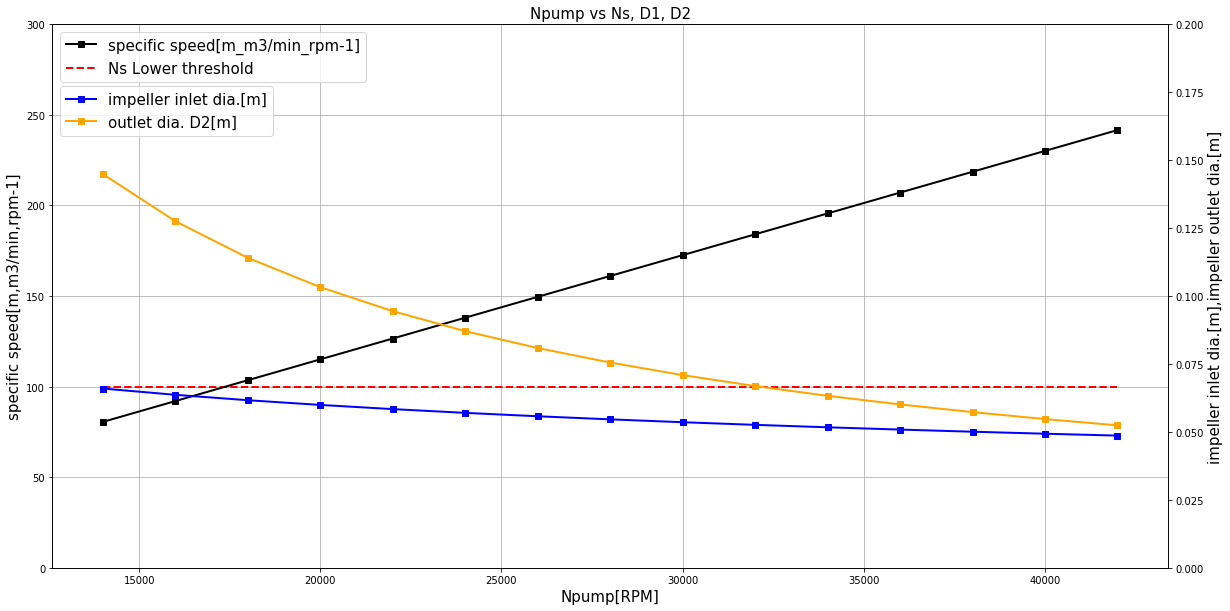

In [10]:
#2軸グラフ用
#回転数vs比速度、インペラ径
#コメント同様
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.style

#グラフサイズ指定
rcParams['figure.figsize'] = 20,10

#データ読み込み
x = df.loc[:,"Npump[RPM]"]
y1 = df.loc[:,"specific speed[m_m3/min_rpm-1]"]
y2 = df.loc[:,"impeller inlet dia.[m]"]
y3 = df.loc[:,"outlet dia. D2[m]"]

#2軸指定
fig,ax1 = plt.subplots()
ax2 = ax1.twinx()

#ライン指定
ax1.plot(x, y1, linewidth=2, color="black", linestyle="solid", marker='s')
ax2.plot(x, y2, linewidth=2, color="blue", linestyle="solid",marker='s')
ax2.plot(x, y3, linewidth=2, color="orange", linestyle="solid",marker='s')

#第1軸のグリッドのみ表示
ax1.grid(True)
ax2.grid(False)

# 閾値の設定
# Ns > 100
ax1.hlines([100], min(x) ,max(x) ,color='red', linewidth = 2,linestyle = "dashed", label = "Ns Lower threshold")

#スケール指定
ax1.set_ylim([0,300])
ax2.set_ylim([0,0.2])

#凡例指定
ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=15)
ax2.legend(bbox_to_anchor=(0, 0.95), loc='upper left', borderaxespad=0.5, fontsize=15)
ax2.legend(bbox_to_anchor=(0, 0.90), loc='upper left', borderaxespad=0.5, fontsize=15)

#ラベル指定
plt.title("Npump vs Ns, D1, D2",fontsize=15)
ax1.set_xlabel("Npump[RPM]", fontsize=15)
ax1.set_ylabel('specific speed[m,m3/min,rpm-1]', fontsize=15)
ax2.set_ylabel('impeller inlet dia.[m],impeller outlet dia.[m]', fontsize=15)

#画像出力
plt.savefig(input_file+'_D1_D2.png',dpi=300)

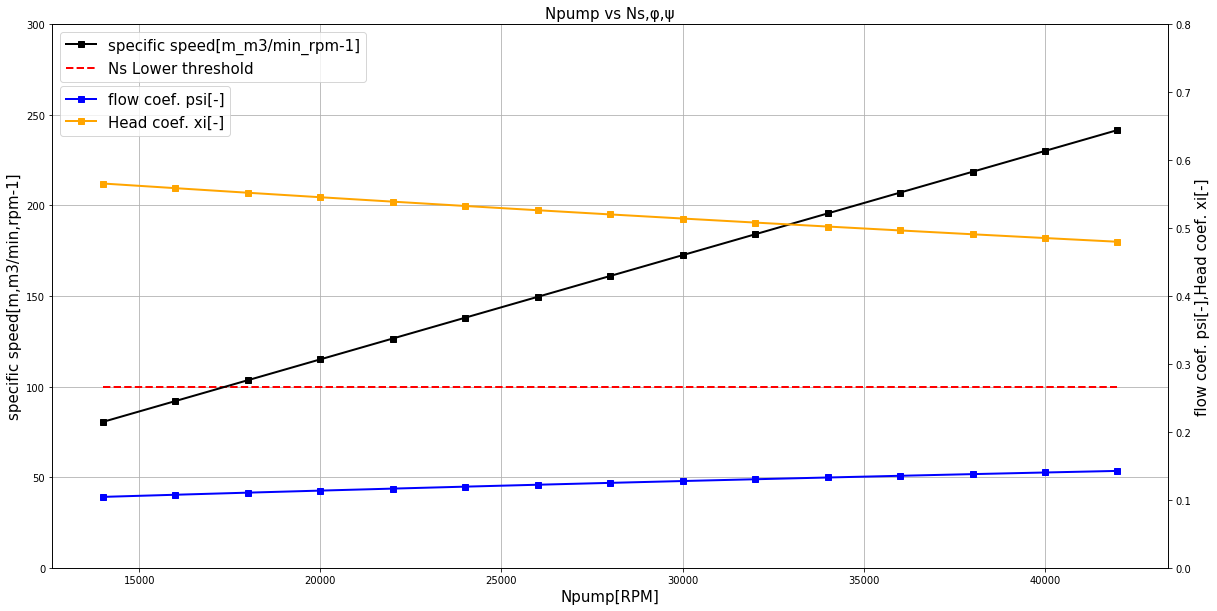

In [11]:
#2軸グラフ用
#回転数vs比速度、φ、ψ
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.style
rcParams['figure.figsize'] = 20,10

x = df.loc[:,"Npump[RPM]"]
y1 = df.loc[:,"specific speed[m_m3/min_rpm-1]"]
y2 = df.loc[:,"flow coef. psi[-]"]
y3 = df.loc[:,"Head coef. xi[-]"]

fig,ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(x, y1, linewidth=2, color="black", linestyle="solid", marker='s')
ax2.plot(x, y2, linewidth=2, color="blue", linestyle="solid",marker='s')
ax2.plot(x, y3, linewidth=2, color="orange", linestyle="solid",marker='s')


ax1.grid(True)
ax2.grid(False)


# 閾値の設定
# Ns > 100
ax1.hlines([100], min(x) ,max(x) ,color='red', linewidth = 2,linestyle = "dashed", label = "Ns Lower threshold")


ax1.set_ylim([0,300])
ax2.set_ylim([0,0.8])


ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=15)
ax2.legend(bbox_to_anchor=(0, 0.95), loc='upper left', borderaxespad=0.5, fontsize=15)
ax2.legend(bbox_to_anchor=(0, 0.90), loc='upper left', borderaxespad=0.5, fontsize=15)


plt.title("Npump vs Ns,φ,ψ",fontsize=15)
ax1.set_xlabel("Npump[RPM]", fontsize=15)
ax1.set_ylabel('specific speed[m,m3/min,rpm-1]', fontsize=15)
ax2.set_ylabel('flow coef. psi[-],Head coef. xi[-]', fontsize=15)


plt.savefig(input_file+'_flow coef.,Head coef..png',dpi=300)

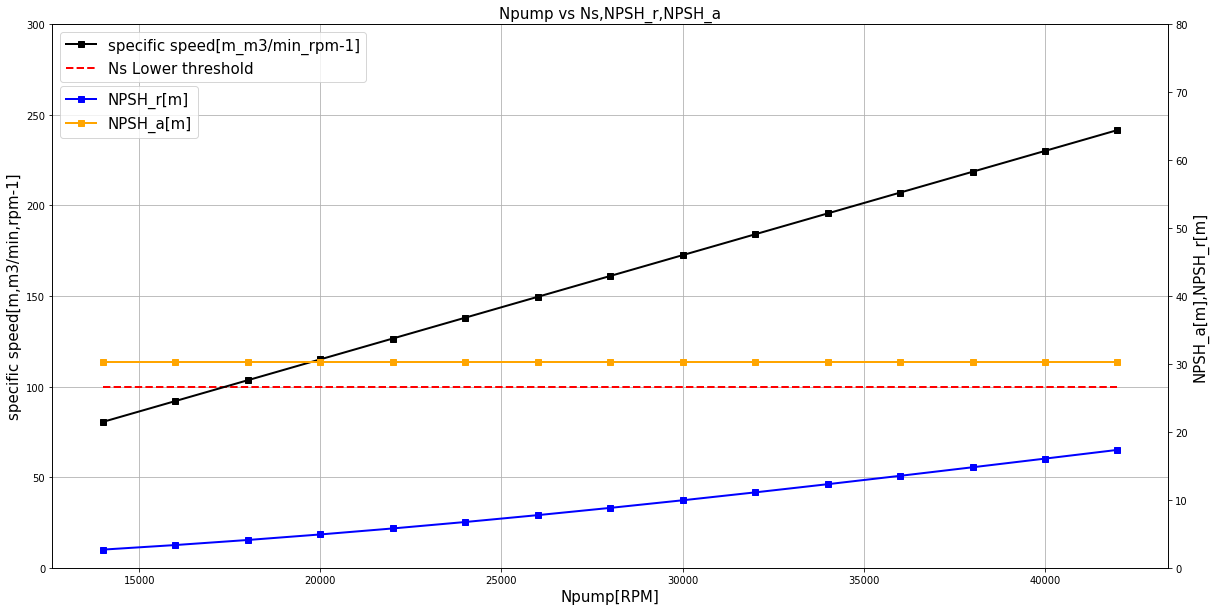

In [12]:
#2軸グラフ用
#回転数vs比速度、吸込性能
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.style
rcParams['figure.figsize'] = 20,10

x = df.loc[:,"Npump[RPM]"]
y1 = df.loc[:,"specific speed[m_m3/min_rpm-1]"]
y2 = df.loc[:,"NPSH_r[m]"]
y3 = df.loc[:,"NPSH_a[m]"]


fig,ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(x, y1, linewidth=2, color="black", linestyle="solid", marker='s')
ax2.plot(x, y2, linewidth=2, color="blue", linestyle="solid",marker='s')
ax2.plot(x, y3, linewidth=2, color="orange", linestyle="solid",marker='s')


ax1.grid(True)
ax2.grid(False)


# Ns > 100
ax1.hlines([100], min(x) ,max(x) ,color='red', linewidth = 2,linestyle = "dashed", label = "Ns Lower threshold")

ax1.set_ylim([0,300])
ax2.set_ylim([0,80])

ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=15)
ax2.legend(bbox_to_anchor=(0, 0.95), loc='upper left', borderaxespad=0.5, fontsize=15)
ax2.legend(bbox_to_anchor=(0, 0.90), loc='upper left', borderaxespad=0.5, fontsize=15)


plt.title("Npump vs Ns,NPSH_r,NPSH_a",fontsize=15)
ax1.set_xlabel("Npump[RPM]", fontsize=15)
ax1.set_ylabel('specific speed[m,m3/min,rpm-1]', fontsize=15)
ax2.set_ylabel('NPSH_a[m],NPSH_r[m]', fontsize=15)


plt.savefig(input_file+'_NPSH',dpi=300)

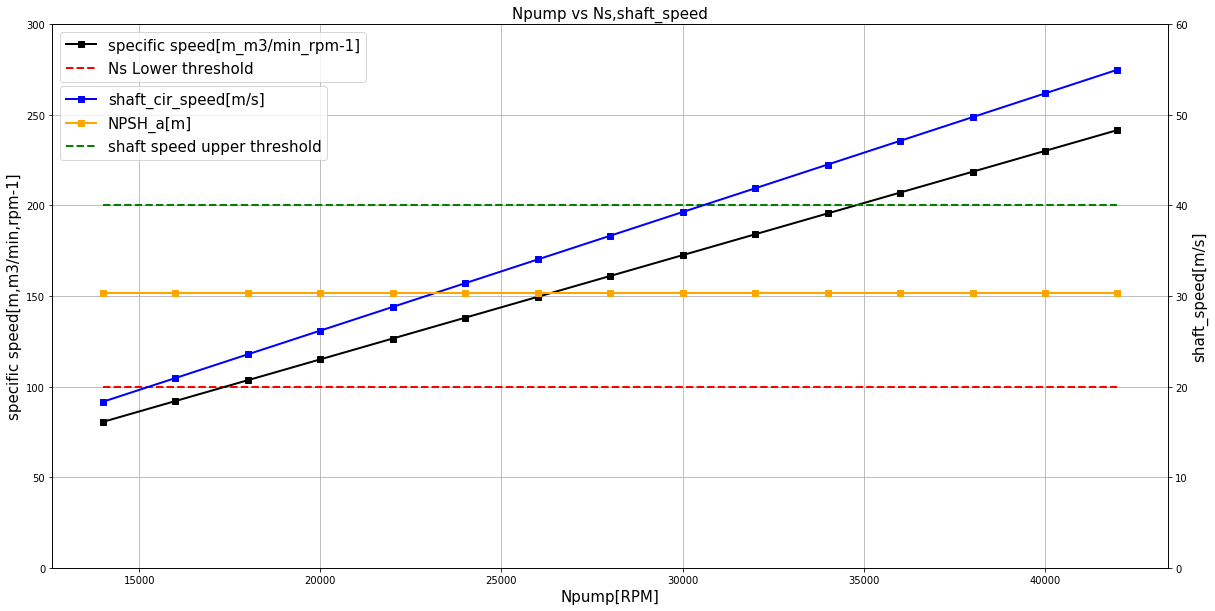

In [13]:
#2軸グラフ用
#回転数vs比速度、シャフト周速度
import matplotlib.pyplot as plt
from pylab import rcParams
import matplotlib.style
rcParams['figure.figsize'] = 20,10

x = df.loc[:,"Npump[RPM]"]
y1 = df.loc[:,"specific speed[m_m3/min_rpm-1]"]
y2 = df.loc[:,"shaft_cir_speed[m/s]"]


fig,ax1 = plt.subplots()
ax2 = ax1.twinx()


ax1.plot(x, y1, linewidth=2, color="black", linestyle="solid", marker='s')
ax2.plot(x, y2, linewidth=2, color="blue", linestyle="solid",marker='s')
ax2.plot(x, y3, linewidth=2, color="orange", linestyle="solid",marker='s')


ax1.grid(True)
ax2.grid(False)



# Ns > 100
ax1.hlines([100], min(x) ,max(x) ,color='red', linewidth = 2,linestyle = "dashed", label = "Ns Lower threshold")


# shaft speed < 40
ax2.hlines([40], min(x) ,max(x) ,color='green', linewidth = 2,linestyle = "dashed", label = "shaft speed upper threshold")

ax1.set_ylim([0,300])
ax2.set_ylim([0,60])

ax1.legend(bbox_to_anchor=(0, 1), loc='upper left', borderaxespad=0.5, fontsize=15)
ax2.legend(bbox_to_anchor=(0, 0.9), loc='upper left', borderaxespad=0.5, fontsize=15)


plt.title("Npump vs Ns,shaft_speed",fontsize=15)
ax1.set_xlabel("Npump[RPM]", fontsize=15)
ax1.set_ylabel('specific speed[m,m3/min,rpm-1]', fontsize=15)
ax2.set_ylabel('shaft_speed[m/s]', fontsize=15)


plt.savefig(input_file+'_shaft_speed',dpi=300)